In [63]:
from os import listdir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
from nltk.metrics.distance import edit_distance

In [64]:
MISSING = " "

# Load Data

## Charts

In [65]:
files = listdir("../chart")

dfs_chart = {}
for f in files:
    year = f.split("_")[0]
    month = f.split("_")[1].split(".")[0]

    if dfs_chart.get(year) is None:
        dfs_chart[year] = {}
        
    dfs_chart[year][month] = pd.read_csv("../chart/" + f)

In [66]:
dfs_chart["2006"]["Janvier"].head(3)

,Rank,Artist,Music
0,1,juanes,la camisa negra
1,2,madonna,hung up
2,3,johnny hallyday,mon plus beau noël


In [67]:
chart = []
for k1 in dfs_chart.keys():
    for k2 in dfs_chart[k1].keys():
        chart.append(dfs_chart[k1][k2])
chart = pd.concat(chart)
chart.drop(columns=["Rank"], inplace=True)
chart.drop_duplicates(inplace=True)

## Artists

In [68]:
artist = pd.read_csv("../artist.csv", index_col=0)
artist.fillna(MISSING, inplace=True)

In [69]:
artist.head(3)

,Artist_wiki,Naissance,Pays d'origine,Origine,Nationalité,Pays,Summary
Artist,,,,,,,
jonas brothers,Jonas Brothers,,états-unis,,,états-unis,les jonas brothers est un groupe américain de ...
bob taylor,Bob Taylor,1955,,,américaine,,bob taylor est un luthier américain.
yvonne s. moriarty,,,,,,,


# Analysis

## Analyse des pages wikipédia

In [70]:
artist.value_counts("Artist_wiki").sort_values() #Aucune page en wiki en double, ce qui est un bon signe !

Artist_wiki
LCD Soundsystem      1
1995 (groupe)        1
2 Chainz             1
24kGoldn             1
2NE1                 1
                  ... 
Zkr                  1
Yuksek               1
Zoe Wees             1
MANUEL              17
                   528
Length: 1701, dtype: int64

In [71]:
np.round(artist[artist["Artist_wiki"] == MISSING].shape[0] / artist.shape[0], 2) # 24% des artistes n'ont pas de page en wiki

0.24

In [72]:
chart_c = chart.copy().merge(artist, left_on="Artist", right_on="Artist", how="left")

In [73]:
#Affiche le nb de fois qu'un artiste, sur qui nous n'avons pas donnée, est dans le top 50
chart_c[chart_c["Artist_wiki"] == MISSING].groupby("Artist")["Music"].count().sort_values(ascending=False)

Artist
astrofonik            6
frédérique zoltane    5
narkotek              4
lylloo                3
string color          3
                     ..
gums                  1
guirri mafia          1
groove cats           1
graya                 1
öwnboss               1
Name: Music, Length: 528, dtype: int64

In [74]:
#On recalcul les distances entre les noms d'artistes et les pages wikipédia pour vérifier
def calc_dist(artist, wiki):
    words = ["(chanteur)", "(chanteuse)", "(groupe)", "(rappeur)", "(rappeuse)", "(musicien)", "(chanteur français)", "(france)", "(producteur)", "(artiste)", "(groupe de musique)"]

    if any(w in wiki.lower() for w in words):
        dist = edit_distance(artist.lower().strip(), wiki.lower().split(" (")[0].strip())
        if dist/len(artist) < 0.4:
            return dist
    
    return edit_distance(artist.lower().strip(), wiki.lower().strip())

artist["distance"] = artist.apply(lambda x: calc_dist(x.name, x["Artist_wiki"]), axis=1)
artist["distance_norm"] = artist.apply(lambda x : x["distance"]/len(x.name), axis=1)

In [75]:
artist[artist["Artist_wiki"] != MISSING].sort_values("distance_norm", ascending=False).head() #Nos distances sont bonnes

,Artist_wiki,Naissance,Pays d'origine,Origine,Nationalité,Pays,Summary,distance,distance_norm
Artist,,,,,,,,,
isk,MANUEL,20 mars 2003,,,française,,"ISK, de son vrain nom Kais Ben Baccar, est un ...",6,2.00
glk,MANUEL,,,,française,,"Originaire de Bobigny, en Seine-Saint-Denis",6,2.00
dry,MANUEL,19 novembre 1977,,,française,,Landry Delica a grandi à Sevran en Seine-Saint...,6,2.00
yaro,MANUEL,1996,,,française,,"Yaro, anciennement Sirsy, est un rappeur franç...",5,1.25
1pliké140,MANUEL,1963,,,française,,1PLIKÉ140 est un jeune rappeur français origin...,9,1.00


## Analyse des données sur wikipédia

In [76]:
artist = artist[artist["Artist_wiki"] != MISSING] #On ne garde que les artistes qui ont une page en wiki

In [77]:
#Ajout de la colonne "Missing" pour voir ceux sur qui on n'a pas de données
artist["No data"] = (
    (artist["Naissance"] == MISSING) &
    (artist["Pays d'origine"] == MISSING) &
    (artist["Origine"] == MISSING) &
    (artist["Nationalité"] == MISSING) &
    (artist["Pays"] == MISSING) &
    (artist["Summary"] == MISSING)
)

In [78]:
chart_c = chart.copy().merge(artist, left_on="Artist", right_on="Artist", how="right")

In [79]:
chart_c[chart_c["No data"]].groupby("Artist")["Music"].count().sort_values(ascending=False)[:20]

Artist
rio             3
train           2
jumpy           2
digital         2
infernal        2
africanism      1
mig             1
pearl           1
pat             1
nour            1
noa             1
moonlight       1
michael gray    1
martial         1
marnik          1
mario           1
majestic        1
mag             1
lumberjack      1
petey           1
Name: Music, dtype: int64

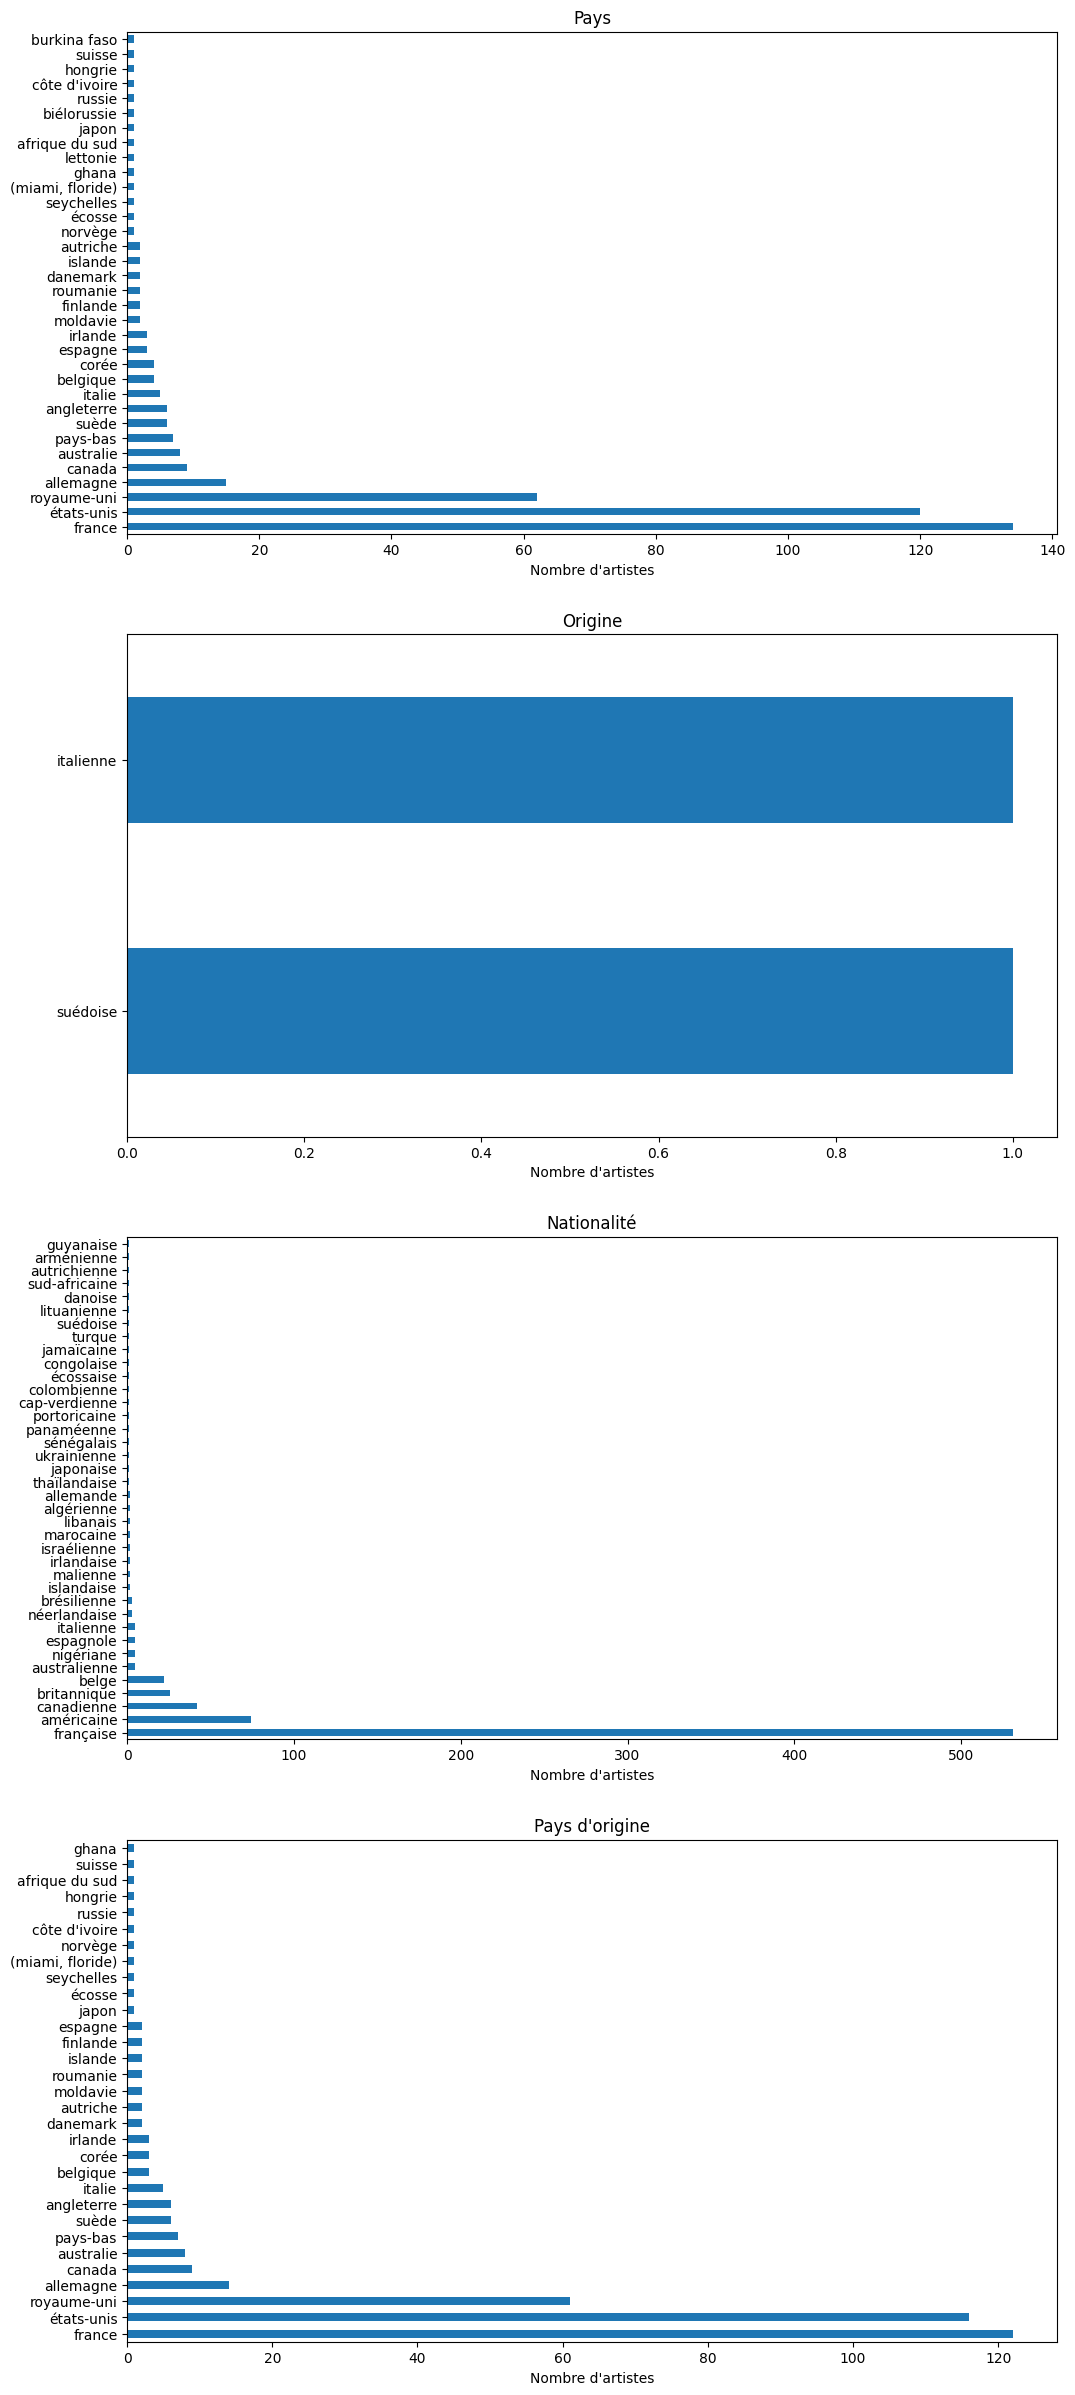

In [80]:
fig, ax = plt.subplots(4, 1, figsize=(12, 30))
for axi, col in zip(ax.flatten(), ["Pays", "Origine", "Nationalité", "Pays d'origine"]):
    artist[col].value_counts()[1:].plot.barh(ax=axi, title=col)
    axi.set(xlabel="Nombre d'artistes")

In [81]:
artist = artist[~artist["No data"]] #On ne garde que les artistes pour lesquels on a des données

In [82]:
def get_nationality(row, words):
    for r in words:
        regex = r"([\d)()\] ]|^)"+ r.lower() + r"([.,\[) ]|$)"

        if not re.search(regex, row["Summary"].lower()) is None:
            return r.lower()
    return MISSING

In [83]:
#On utilise le summary pour récupérer la nationalité
avant = artist[artist["Nationalité"] == MISSING].shape[0]

artist.loc[artist["Nationalité"] == MISSING, "Nationalité"] = artist[artist["Nationalité"] == MISSING].apply(lambda x: get_nationality(x, artist["Nationalité"].unique()), axis=1)

apres = artist[artist["Nationalité"] == MISSING].shape[0]

print(avant - apres) #On a récupéré 196 nationalités

196


In [84]:
def get_pays(row, words):
    for r in words:
        regex = r"([\d)()\] ]|^)"+ r.lower() + r"([.,\[) ]|$)"

        if not re.search(regex, row["Naissance"].lower()) is None:
            return r.lower()
    return MISSING

In [86]:
#On utilise le summary pour récupérer la Pays
avant = artist[artist["Pays"] == MISSING].shape[0]

artist.loc[artist["Pays"] == MISSING, "Pays"] = artist[artist["Pays"] == MISSING].apply(lambda x: get_pays(x, artist["Pays"].unique()), axis=1)

apres = artist[artist["Pays"] == MISSING].shape[0]

print(avant - apres) #On a récupéré 642 Pays

642


In [87]:
avant = artist[artist["Nationalité"] == MISSING].shape[0]

In [88]:
#On récupère la nationalité à partir du pays
pays_replace = [
    ("française", "france"),
    ("américaine", "états-unis"),
    ("britannique", "royaume-uni"),
    ("britannique", "angleterre"),
    ("canadienne", "canada"),
    ("belge", "belgique"),
    ("allemande", "allemagne"),
    ("néerlandaise", "pays-bas"),
    ("australienne", "australie"),
    ("suédoise", "suède"),
    ("italienne", "italie"),
    ("espagnole", "espagne"),
    ("suisse", "suisse"),
    ("irlanndaise", "irlande"),
    ("écossaise", "écosse"),
    ("coréenne", "corée"),
    ("norvégienne", "norvège"),
    ("roumaine", "roumanie"),
    ("autrichienne", "autriche"),
    ("africaine", "afrique"),
    ("islandaise", "islande"),
    ("moldave", "moldavie"),
    ("danoise", "danemark"),
    ("japonaise", "japon"),
    ("russe", "russie"),
    ("finlandaise", "finlande"),
    ("ivoirienne", "côte d'ivoire"),
    ("seychelloise", "seychelles"),
    ("lettonne", "lettonie"),
    ("burkinabé", "burkina faso"),
    ("biélorusse", "biélorussie"),
    ("ghanaise", "ghana"),
    ("hongroise", "hongrie"),
]

for n1, n2 in pays_replace:
    artist.loc[(artist["Nationalité"] == MISSING) & (artist["Pays"] == n2), "Nationalité"] = n1
    artist.loc[(artist["Nationalité"] == MISSING) & (artist["Pays d'origine"] == n2), "Nationalité"] = n1

In [89]:
# Les origines sont transposées avec sur la nationalité
artist.loc[(artist["Nationalité"] == MISSING) & (artist["Origine"] != MISSING), "Nationalité"] = artist.loc[(artist["Nationalité"] == MISSING) & (artist["Origine"] != MISSING), "Origine"]

In [90]:
apres = artist[artist["Nationalité"] == MISSING].shape[0]
print(avant - apres) #On a récupéré 497 nationalités

497


In [91]:
artist["Nationalité"].value_counts()

française        587
américaine       359
                 192
britannique      173
canadienne        51
belge             30
allemande         29
suédoise          27
néerlandaise      26
australienne      25
italienne         21
espagnole         17
suisse             8
écossaise          7
irlanndaise        6
coréenne           6
nigériane          5
brésilienne        4
islandaise         4
norvégienne        4
autrichienne       4
marocaine          4
danoise            3
colombienne        3
irlandaise         3
roumaine           3
jamaïcaine         3
moldave            3
japonaise          3
malienne           2
libanais           2
algérienne         2
russe              2
finlandaise        2
israélienne        2
seychelloise       1
sénégalais         1
panaméenne         1
ghanaise           1
lettonne           1
ukrainienne        1
burkinabé          1
cap-verdienne      1
arménienne         1
congolaise         1
turque             1
lituanienne        1
sud-africaine

In [92]:
artist[(artist["Nationalité"] == MISSING) & (artist["Naissance"] != MISSING)]

,Artist_wiki,Naissance,Pays d'origine,Origine,Nationalité,Pays,Summary,distance,distance_norm,No data
Artist,,,,,,,,,,
jawsh 685,Jawsh 685,"5 novembre 2002 (20 ans)auckland, nouvelle-zél...",,,,,"joshua christian nanai, dit jawsh 685 est un p...",0,0.0000,False
carlprit,Carlprit,"20 mai 1986 (36 ans)harare, zimbabwe",,,,,"carlprit, de son vrai nom rudi schwamborn, né ...",0,0.0000,False
poupie,Poupie,2 mai 1998 (24 ans)tours,,,,,,0,0.0000,False
asap rocky,ASAP Rocky,3 octobre 1988 (34 ans)harlem (new york),,,,,"rakim athelaston mayers, dit asap rocky (styli...",0,0.0000,False
soso maness,Soso Maness,"21 mars 1987 (35 ans)marseille, bouches-du-rhône",,,,,,0,0.0000,False
...,...,...,...,...,...,...,...,...,...,...
s.pri noir,S.Pri Noir,1986[1],,,,,,0,0.0000,False
carolina marquez,Carolina Márquez,juillet 1975 (47 ans)bogota (colombie),,,,,"carolina márquez, née à bogota, est une disc-j...",1,0.0625,False
juanes,Juanes,"9 août 1972 (50 ans)medellin, colombie",,,,,"juan esteban aristizábal vásquez, alias juanes...",0,0.0000,False


# Francophone

# Commune france

In [125]:
region = pd.read_csv("../france/departements-france.csv")
departement = pd.read_csv("../france/departements-france.csv")
commune = pd.read_csv("../france/nb_habitant.csv")

In [126]:
commune["nb_habitant"] = commune["nb_habitant"].str.replace(" ", "")
commune["nb_habitant"] = commune["nb_habitant"].astype("int")

In [127]:
def get_localisation(row, localisation):
    for r in localisation:
        regex = r"([\d)()\] ]|^)"+ r.lower() + r"([.,\[) ]|$)"

        if (not re.search(regex, row["Summary"].lower()) is None) or (not re.search(regex, row["Naissance"].lower()) is None):
            return r.lower()
    return MISSING

In [128]:
artist["Region"] = artist.apply(lambda x: get_localisation(x, region["nom_region"]), axis=1)

In [129]:
artist["Commune"] = artist.apply(lambda x: get_localisation(x, commune[commune["nb_habitant"] > 2000]["Ville"]), axis=1)

In [130]:
artist["Departement"] = artist.apply(lambda x: get_localisation(x, departement["nom_departement"]), axis=1)

In [139]:
for col in ["Region", "Commune", "Departement"]:
    print("-"*50)
    print(col)
    print("-"*50)
    print(artist[col].value_counts()[1:])
    print("Total : ", artist[col].value_counts()[1:].sum())

--------------------------------------------------
Region
--------------------------------------------------
guadeloupe                    7
guyane                        5
bretagne                      3
martinique                    3
provence-alpes-côte d'azur    3
normandie                     2
hauts-de-france               2
la réunion                    1
corse                         1
pays de la loire              1
île-de-france                 1
Name: Region, dtype: int64
Total :  29
--------------------------------------------------
Commune
--------------------------------------------------
paris                  86
marseille              21
nice                   11
lyon                    9
toulouse                7
                       ..
pontoise                1
chambray-lès-tours      1
saint-cyr-l'école       1
tassin-la-demi-lune     1
yerres                  1
Name: Commune, Length: 198, dtype: int64
Total :  439
--------------------------------------------------

In [132]:
artist["No localisation"] = (
    (artist["Region"] == MISSING) &
    (artist["Commune"] == MISSING) &
    (artist["Departement"] == MISSING)
)

In [133]:
artist.to_csv("../test_localisation.csv", encoding="utf-8-sig")